In [1]:
import pandas as pd
import numpy as np
from pathlib import Path
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import KFold, cross_val_score , cross_validate,train_test_split
from sklearn.ensemble import GradientBoostingClassifier , RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler , OneHotEncoder , OrdinalEncoder
from sklearn.metrics import accuracy_score, roc_auc_score, recall_score, precision_score , roc_curve

# Data Preprocessing

In [2]:
ROOT = Path.cwd().parent.parent
DATA_DIR = ROOT / "Subscribly" / "data" / "raw"

In [3]:
df = pd.read_csv(DATA_DIR / "customer_churn_dataset-training-master.csv")

In [4]:
df.head(5)

,CustomerID,Age,Gender,Tenure,Usage Frequency,Support Calls,Payment Delay,Subscription Type,Contract Length,Total Spend,Last Interaction,Churn
0,2.0,30.0,Female,39.0,14.0,5.0,18.0,Standard,Annual,932.0,17.0,1.0
1,3.0,65.0,Female,49.0,1.0,10.0,8.0,Basic,Monthly,557.0,6.0,1.0
2,4.0,55.0,Female,14.0,4.0,6.0,18.0,Basic,Quarterly,185.0,3.0,1.0
3,5.0,58.0,Male,38.0,21.0,7.0,7.0,Standard,Monthly,396.0,29.0,1.0
4,6.0,23.0,Male,32.0,20.0,5.0,8.0,Basic,Monthly,617.0,20.0,1.0


1. Dropping Customer ID.

In [5]:
df.drop(columns = 'CustomerID' , inplace = True)

In [6]:
df['Age'].min()

np.float64(18.0)

In [7]:
df.dropna(inplace = True)

In [8]:
df.isnull().sum()

Age                  0
Gender               0
Tenure               0
Usage Frequency      0
Support Calls        0
Payment Delay        0
Subscription Type    0
Contract Length      0
Total Spend          0
Last Interaction     0
Churn                0
dtype: int64

In [9]:
df.drop_duplicates(inplace = True)

Column Conversion

In [10]:
num_cols = df.select_dtypes(include = np.number)

In [11]:
num_cols.drop(columns = ['Total Spend'] , inplace = True)

In [12]:
num_cols = num_cols.columns.to_list()

In [13]:
for col in num_cols :
    df[col] = df[col].astype(int)

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 440832 entries, 0 to 440832
Data columns (total 11 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Age                440832 non-null  int64  
 1   Gender             440832 non-null  object 
 2   Tenure             440832 non-null  int64  
 3   Usage Frequency    440832 non-null  int64  
 4   Support Calls      440832 non-null  int64  
 5   Payment Delay      440832 non-null  int64  
 6   Subscription Type  440832 non-null  object 
 7   Contract Length    440832 non-null  object 
 8   Total Spend        440832 non-null  float64
 9   Last Interaction   440832 non-null  int64  
 10  Churn              440832 non-null  int64  
dtypes: float64(1), int64(7), object(3)
memory usage: 40.4+ MB


Creating Age Buckets

In [15]:
df["age_bucket"] = pd.cut(
    df["Age"],
    bins=[18, 25, 35, 45, 55, 70],
    right=False
)

Training the Model

In [16]:
col_add = df.pop('age_bucket')

In [17]:
df.insert(10,'age_bucket',col_add)

In [18]:
df.drop(columns = 'Age',inplace = True)

In [19]:
df

,Gender,Tenure,Usage Frequency,Support Calls,Payment Delay,Subscription Type,Contract Length,Total Spend,Last Interaction,age_bucket,Churn
0,Female,39,14,5,18,Standard,Annual,932.00,17,"[25, 35)",1
1,Female,49,1,10,8,Basic,Monthly,557.00,6,"[55, 70)",1
2,Female,14,4,6,18,Basic,Quarterly,185.00,3,"[55, 70)",1
3,Male,38,21,7,7,Standard,Monthly,396.00,29,"[55, 70)",1
4,Male,32,20,5,8,Basic,Monthly,617.00,20,"[18, 25)",1
...,...,...,...,...,...,...,...,...,...,...,...
440828,Male,54,15,1,3,Premium,Annual,716.38,8,"[35, 45)",0
440829,Female,8,13,1,20,Premium,Annual,745.38,2,"[25, 35)",0
440830,Male,35,27,1,5,Standard,Quarterly,977.31,9,"[25, 35)",0
440831,Male,55,14,2,0,Standard,Quarterly,602.55,2,"[25, 35)",0


In [20]:
X = df.iloc[:,:-1]
y = df['Churn']

Applying Transformers and Pipeline Logic

In [21]:
num_cols = df.drop(columns = "Churn").select_dtypes(include = np.number).columns.to_list()

In [22]:
ohe_cols = df.select_dtypes(include = [object , "category"]).drop(columns = "Subscription Type").columns.to_list()

In [23]:
ohe_cols

['Gender', 'Contract Length', 'age_bucket']

In [24]:
ord_cols = [df['Subscription Type'].name]

In [25]:
ord_cols

['Subscription Type']

In [26]:
preprocessor = ColumnTransformer(
    transformers = [
    ("numerical columns" , StandardScaler() , num_cols),
    ("One hot columns" , OneHotEncoder() , ohe_cols),
    ("ord_cols" , OrdinalEncoder() , ord_cols)
], 
remainder = "passthrough"
)

In [27]:
X_train , X_test , y_train , y_test = train_test_split(X,y,test_size = 0.2 ,random_state = 42)

Creating Pipeline

In [28]:
pipeline = Pipeline( steps =
    [
        ('Preprocessor' , preprocessor),
        ('estimator' , LogisticRegression())
    ]
)

In [29]:
Kfold = KFold(n_splits = 10 , shuffle = True , random_state = 42)
scores = cross_val_score(pipeline,X,y,cv=Kfold , scoring='roc_auc')

In [30]:
scores

array([0.97188617, 0.97313283, 0.97179001, 0.97265773, 0.97282815,
       0.97035341, 0.9732683 , 0.97272495, 0.97265683, 0.97293436])

In [31]:
scores.mean()

np.float64(0.9724232734212916)

In [32]:
pipeline.fit(X_train , y_train)

,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('Preprocessor', ...), ('estimator', ...)]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"transformers transformers: list of tuplesList of (name, transformer, columns) tuples specifying thetransformer objects to be applied to subsets of the data.name : str Like in Pipeline and FeatureUnion, this allows the transformer and its parameters to be set using ``set_params`` and searched in grid search.transformer : {'drop', 'passthrough'} or estimator Estimator must support :term:`fit` and :term:`transform`. Special-cased strings 'drop' and 'passthrough' are accepted as well, to indicate to drop the columns or to pass them through untransformed, respectively.columns : str, array-like of str, int, array-like of int, array-like of bool, slice or callable Indexes the data on its second axis. Integers are interpreted as positional columns, while strings can reference DataFrame columns by name. A scalar string or int should be used where ``transformer`` expects X to be a 1d array-like (vector), otherwise a 2d array will be passed to the transformer. A callable is passed the input data `X` and can return any of the above. To select multiple columns by name or dtype, you can use :obj:`make_column_selector`.","[('numerical columns', ...), ('One hot columns', ...), ...]"
,"remainder remainder: {'drop', 'passthrough'} or estimator, default='drop'By default, only the specified columns in `transformers` aretransformed and combined in the output, and the non-specifiedcolumns are dropped. (default of ``'drop'``).By specifying ``remainder='passthrough'``, all remaining columns thatwere not specified in `transformers`, but present in the data passedto `fit` will be automatically passed through. This subset of columnsis concatenated with the output of the transformers. For dataframes,extra columns not seen during `fit` will be excluded from the outputof `transform`.By setting ``remainder`` to be an estimator, the remainingnon-specified columns will use the ``remainder`` estimator. Theestimator must support :term:`fit` and :term:`transform`.Note that using this feature requires that the DataFrame columnsinput at :term:`fit` and :term:`transform` have identical order.",'passthrough'
,"sparse_threshold sparse_threshold: float, default=0.3If t

In [33]:
y_pred = pipeline.predict(X_test)

In [34]:
accuracy_score(y_test,y_pred)

0.922714847958987

In [35]:
roc_auc_score(y_test,y_pred)

0.9249426683919563

In [36]:
y_score = pipeline.predict_proba(X_test)[:,1]

In [37]:
roc_auc_score(y_test, y_score)

0.9725066625363231

In [38]:
fpr, tpr, thresholds = roc_curve(y_test, y_score)

In [39]:
roc_auc = roc_auc_score(y_test, y_score)


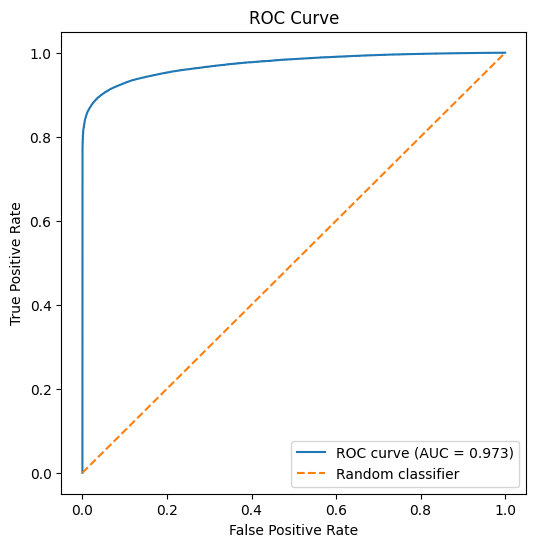

In [40]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], linestyle='--', label='Random classifier')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

# Now lets Try to Select the best models from all the algorithms

In [41]:
def scorer(model_name, model):
    
    output = []
    
    output.append(model_name)
    
    pipeline = Pipeline( steps =
    [
        ('Preprocessor' , preprocessor),
        ('estimator' , model)
    ]
    )
    
    # K-fold cross-validation
    kfold = KFold(n_splits=5, shuffle=True, random_state=42)
    scores = cross_val_score(pipeline, X, y, cv=kfold, scoring='roc_auc')
    
    output.append(scores.mean())
    
    X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42)
    
    pipeline.fit(X_train,y_train)
    
    y_scores = pipeline.predict_proba(X_test)[:,1]
    
    
    output.append(roc_auc_score(y_test,y_scores))
    
    return output

In [42]:
model_dict = {
'LogisticRegression': LogisticRegression(),
'GradientBoostingClassifier': GradientBoostingClassifier(),
'RandomForestClassifier' : RandomForestClassifier(),
'DecisionTreeClassifier' : DecisionTreeClassifier(),
'KNeighborsClassifier' : KNeighborsClassifier(),
'XGBClassifier' : XGBClassifier()
}

In [43]:
model_output = []

for model_name , model in model_dict.items():
    out = scorer(model_name,model)
    print(model_name)
    model_output.append(out)


LogisticRegression
GradientBoostingClassifier
RandomForestClassifier
DecisionTreeClassifier
KNeighborsClassifier
XGBClassifier


In [44]:
model_output

[['LogisticRegression', np.float64(0.9724251436848919), 0.9725066625363231],
 ['GradientBoostingClassifier',
  np.float64(0.9980936314584665),
  0.998202213242448],
 ['RandomForestClassifier',
  np.float64(0.9975490398270092),
  0.9975777495753162],
 ['DecisionTreeClassifier',
  np.float64(0.9829680398103949),
  0.9827223214612274],
 ['KNeighborsClassifier', np.float64(0.9838502734382981), 0.984087950857241],
 ['XGBClassifier', np.float64(0.9980630055617912), 0.9980735771458068]]

In [46]:
model_output = pd.DataFrame(model_output , columns=['model','cross_val_scores','roc_auc_score'])

In [49]:
model_output.sort_values(by='roc_auc_score',ascending=False)

,model,cross_val_scores,roc_auc_score
1,GradientBoostingClassifier,0.998094,0.998202
5,XGBClassifier,0.998063,0.998074
2,RandomForestClassifier,0.997549,0.997578
4,KNeighborsClassifier,0.983850,0.984088
3,DecisionTreeClassifier,0.982968,0.982722
0,LogisticRegression,0.972425,0.972507
